# GMM and EM
Gaussian Mixture Models and Expectation Maximization  

Here we show canned and homgrown implementations.

## Using a library call
Follow tutorial in [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class GaussianMixture.

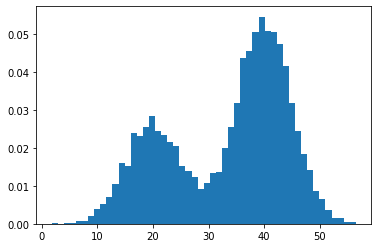

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [40.08491144] wgt= 0.6619829885555241 Cov= 23.93286498148689
Gaussian 1 mean= [20.16155396] wgt= 0.338017011444476 Cov= 25.59689289093257


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 1
Predicted class of a point on the right: 0


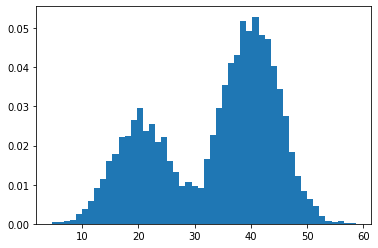

In [5]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=5, size=3000) 
G1 = normal(loc=mean1, scale=5, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=5, size=6000) 
    G1 = normal(loc=mean1, scale=5, size=3000)
plot(G0,G1)

## Homegrown version

In [31]:
import scipy.stats as ss
import numpy as np
def assign_probs(mean,stdev,data):
    dist = ss.norm(mean,stdev)
    probs=np.asarray([dist.pdf(x) for x in data])
    return probs
def assign_weights(probs1,probs2):
    length = len(probs1)
    weights1=np.zeros(length)
    weights2=np.zeros(length)
    for i in range(length):    # do without for loop                  
        weights1[i]=probs1[i]/probs2[i]
        weights2[i]=probs2[i]/probs1[i]
    return weights1,weights2
def update_mean(weights,data):
    length = len(data)
    weighted=np.zeros(length)
    for i in range(length):   # do without for loop
        weighted[i]=data[i]*weights[i]  
    mean=sum(weighted)/sum(weights)
    return mean
def update_stdev(mean,weights,data):
    sse = 0
    for i in range(len(data)):   # do without for loop
        sse += ((mean-data[i])*weights[i])**2
    stdev=float(np.sqrt(sse/sum(weights)))
    return stdev
def iterative_2_means_delta(mean1,mean2,data,delta,iter):
    # initial guess is both equal to overall
    stdev1=np.std(data)
    stdev2=update_stdev(np.mean(data),np.ones(len(data)),data)  # should be same
    print('Initial means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    for i in range(iter):
        probs1=assign_probs(mean1,stdev1,data)
        probs2=assign_probs(mean2,stdev2,data)
        weights1,weights2 = assign_weights(probs1,probs2)
        mean1 = update_mean(weights1,data)
        mean2 = update_mean(weights2,data)
        stdev1 = update_stdev(mean1,weights1,data)
        stdev2 = update_stdev(mean2,weights2,data)
        print('Intermediate means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    print()
    print('Final means: %d +/- %d, %d +/- %d'%(mean1,stdev1,mean2,stdev2))
    return mean1,mean2,stdev1,stdev2

In [32]:
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
guess1 = 15
guess2 = 30
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
mean1,mean2,stdev1,stdev2=iterative_2_means_delta(guess1,guess2,X,0.01,20)


Initial means: 15 +/- 10, 30 +/- 10
Intermediate means: 19 +/- 12, 42 +/- 25
Intermediate means: 24 +/- 12, 42 +/- 17
Intermediate means: 24 +/- 13, 41 +/- 12
Intermediate means: 20 +/- 21, 40 +/- 9
Intermediate means: 13 +/- 197, 40 +/- 8
Intermediate means: 7 +/- 383, 39 +/- 18
Intermediate means: 29 +/- 3, 35 +/- 34
Intermediate means: 30 +/- 7, 0 +/- 10155077
Intermediate means: 33 +/- 5485, 26 +/- 0


<ipython-input-31-7387757ec209>:12: RuntimeWarning: divide by zero encountered in true_divide
  weights1[i]=probs1[i]/probs2[i]
<ipython-input-31-7387757ec209>:20: RuntimeWarning: invalid value encountered in double_scalars
  mean=sum(weighted)/sum(weights)


ValueError: cannot convert float NaN to integer